# **Groot Image Editing Demo using DDIM Inversion**
Using the dreambooth fine-tuned model with inversion to edit images, including a gradio demo editing images to insert groot instead of the image's subject



In [1]:
!pip install -q transformers diffusers accelerate gradio

In [2]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
# Load a pipeline
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
model_id = 'LinoyTsaban/dreambooth-groot' #@param
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    # torch_dtype=torch.float16,
).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [4]:
import ipywidgets as widgets

# choose how to upload image (url or path to local file)
path_type = "file"
drop_down = widgets.Dropdown(
    options=["file", "link"],
    description="type:",
    disabled=False,
)

def dropdown_handler(change):
    global path_type
    path_type = change.new

drop_down.observe(dropdown_handler, names="value")
display(drop_down)

Dropdown(description='type:', options=('file', 'link'), value='file')

In [5]:
# load image to edit and generate its latents with the appropriate prompt
def load_image(path, size=(512, 512)):
  if path_type == 'link':
    response = requests.get(url=path,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
  else: # path to file
    img = Image.open(path).convert('RGB')
  
  if size is not None:
        img = img.resize(size)
  return img

In [6]:
def encode_image(input_image):
  # encode with VAE
 with torch.no_grad(): 
   latent = pipe.vae.encode(tfms.ToTensor()(input_image).unsqueeze(0).to(device)*2-1) # Note scaling
 start_latents = 0.18215 * latent.latent_dist.sample()
 return start_latents

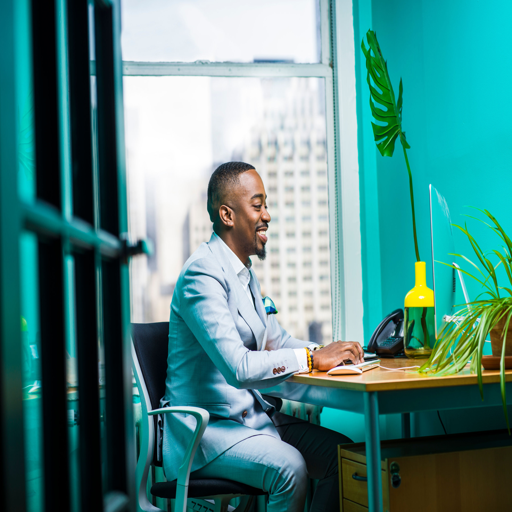

In [8]:
# choose image to edit, input prompt and editing prompt, sanity check
img_path = 'https://images.pexels.com/photos/2422278/pexels-photo-2422278.jpeg' #@param
input_image_prompt = "Photograph of a man sitting in front of keyboard" # @param
replace_to_groot = "man" # @param
edit_prompt = input_image_prompt.replace(replace_to_groot, "groot")
img=load_image(img_path)
img

In [9]:
## Inversion
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
           prompt, device, 
           num_images_per_prompt, 
           do_classifier_free_guidance, 
           negative_prompt
    )

    # latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1: continue

        t = timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps))#t
        next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1-alpha_t).sqrt()*noise_pred)*(alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred


        # Store
        intermediate_latents.append(latents)
            
    return torch.cat(intermediate_latents)


In [10]:
# Sample function (regular DDIM)

@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            edit_prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

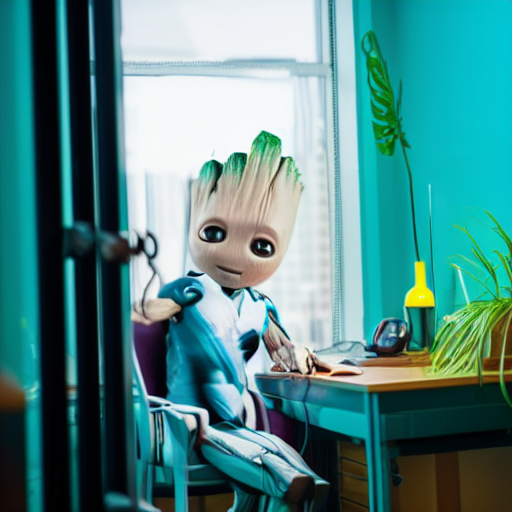

In [11]:
import requests
from io import BytesIO 

start_step=20 # @param 
guidance_scale=3.5 # @param
num_inference_steps=50 # @param
num_images_per_prompt=1 # @param 
do_classifier_free_guidance=True # @param
negative_prompt=''# @param
device=device

def edit(img_path, input_image_prompt, edit_prompt):
    input_image = load_image(img_path)
    starting_latents = encode_image(input_image)

    inverted_latents = invert(starting_latents, 
                              input_image_prompt,
                              num_inference_steps=num_inference_steps)
    
    final_im = sample(edit_prompt, 
                      start_latents=inverted_latents[-(start_step+1)][None], 
                      start_step=start_step, 
                      num_inference_steps=num_inference_steps, 
                      guidance_scale=guidance_scale)[0]
    return final_im

edit(img_path, input_image_prompt, edit_prompt)

# **Demo**

In [ ]:
import gradio as gr
from PIL import Image


def edit(input_image, input_image_prompt, replace_prompt,guidance_scale, num_inference_steps,start_step):
    edit_prompt = input_image_prompt.replace(replace_prompt, 'groot figurine')
    starting_latents = encode_image(input_image)
    inverted_latents = invert(starting_latents, 
                              input_image_prompt,
                              num_inference_steps=num_inference_steps)
    
    final_im = sample(edit_prompt, 
                      start_latents=inverted_latents[-(start_step+1)][None], 
                      start_step=start_step, 
                      num_inference_steps=num_inference_steps, 
                      guidance_scale=guidance_scale)[0]
    return final_im


# See the gradio docs for the types of inputs and outputs available
inputs = [
    gr.Image(label="input image", shape=(512, 512)),
    gr.Textbox(label="input prompt"),
    gr.Textbox(label="what to replace with groot"),
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=5),
    gr.Slider(label="num_inference_steps", minimum=0, maximum=400, value=50),
    gr.Slider(label="start_step", minimum=0, maximum=30, value=20),
   
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=edit,
    inputs=inputs,
    outputs=outputs,
)
demo.queue(concurrency_count=5)
demo.launch(debug=True)  # debug=True allows you to see errors and output in Colab

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://70e2579f40c8a2744e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co./spaces


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]